In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plotSamplesOneHots(labels_of_samples, output_file=False):
    '''
    labels_of_samples of shape (num_samples, x, y, num_onehots)
    '''
    if len(labels_of_samples.shape) != 4:
        print("Incorrect input size - should be (num_samples, x, y, num_onehots)")
    num_samples = labels_of_samples.shape[0]
    num_onehots = labels_of_samples.shape[-1]
    figure_size = (4*num_onehots, 4*num_samples)
    fig, ax = plt.subplots(num_samples, num_onehots, sharex=True, sharey=True, figsize=figure_size)
    for i in range(num_samples):
        for j in range(num_onehots):
            ax[i, j].imshow(labels_of_samples[i,...,j], aspect="auto")
    fig.tight_layout()
    plt.show()
    if output_file == True:
        fig.savefig(output_file)



def oneHotEncode(initial_array):
    '''
    One hot encode the labels
    '''
    allowed_max_class_num = 3
    output_shape = list(initial_array.shape)
    output_shape[-1] = initial_array.max()
    output_array_dims = list(initial_array.shape)
    output_array_dims.append(4)
    output_array = np.zeros(output_array_dims)
    for image_i in range(0, initial_array.shape[0]):
        for class_num in range(0, allowed_max_class_num):
            for x in range(0, initial_array.shape[1]):
                for y in range(0, initial_array.shape[2]):
                    if initial_array[image_i, x, y] == class_num:
                        output_array[image_i, x, y, class_num] = 1

        class_num = allowed_max_class_num
        for x in range(0, initial_array.shape[1]):
            for y in range(0, initial_array.shape[2]):
                if initial_array[image_i, x, y] >= allowed_max_class_num:
                    output_array[image_i, x, y, class_num] = 1
    return output_array


def findNearestNeighbourLabel(array):
    center = int(array.shape[0]/2)
    labels_count = np.zeros(5)
    for x in range(array.shape[0]):
        for y in range(array.shape[1]):
            if (x != center) or (y != center):
                temp_label = array[x, y]
                labels_count[temp_label] += 1
    return labels_count.argmax()
    

def cleanLabelNearestNeighbour(label):
    '''
    Corrects incorrect labels in a single image based on a threshold on the number of 
    nearest neighbours with the same label
    '''
    x_length = label.shape[0]
    y_length = label.shape[1]
    num_of_classes = 4
    cleaned_labels = np.zeros((x_length, y_length, 4))
    for x in range(1,x_length-1):
        for y in range(1, y_length-1):
            temp_label = label[x,y]
            if temp_label >3: # if labeled as 4 or above
                temp_label = findNearestNeighbourLabel(label[(x-1):(x+2), (y-1):(y+2)])
                cleaned_labels[x, y, temp_label] = 1
            elif temp_label > 0:
                num_labels_in_3x3 = len(np.where(label[(x-1):(x+2), (y-1):(y+2)]==temp_label)[0])
                if num_labels_in_3x3 > 3:
                    cleaned_labels[x, y, temp_label] = 1
                else:
                    temp_label = findNearestNeighbourLabel(label[(x-1):(x+2), (y-1):(y+2)])
                    cleaned_labels[x, y, temp_label] = 1
        non_zero_array = cleaned_labels[..., 1:].sum(axis=2).astype('bool')
        cleaned_labels[..., 0] = np.ones((x_length, y_length), dtype='bool')^non_zero_array
    return cleaned_labels

def cleanLabelNearestNeighbour_alllabels(labels):    
    '''
    Cleans incorrect labels
    '''
    num_labels = labels.shape[0]
    num_of_classes = 4
    cleaned_dim = list(labels.shape)
    cleaned_dim.append(num_of_classes)
    cleaned_labels = np.zeros(cleaned_dim)
    for image_i in range(num_labels):
        print('Preprocessing image %d of %d' % (image_i, num_labels))
        cleaned_labels[image_i,...] = cleanLabelNearestNeighbour(labels[image_i, ...])
    return cleaned_labels


def label012Chromosomes(labels):
    '''
    Input array of (num_samples, x, y, 4)
    Returns array of (num_samples, x, y, 3) where chromosome A and chromosome B are merged
    '''
    labels[...,1] = labels[...,1:3].sum(axis=-1)
    return labels[...,[0,1,3]]
    

def makeXbyY(data, X, Y):
    '''
    Crop data to size X by Y
    '''
    if len(data.shape) < 3:
        print('Input should be of size (num_samples, x, y,...)')
    data_x_start = int((data.shape[1]-X)/2)
    data_y_start = int((data.shape[1]-Y)/2)
    arrayXbyY = data[:, (data_x_start):(data_x_start + X), (data_y_start):(data_y_start + Y),...]
    return arrayXbyY

def meanIOU_per_image(y_pred, y_true):
    '''
    Calculate the IOU, averaged across images
    '''
    if len(y_pred.shape) < 3 or (y_pred.shape[2]<4):
        print('Wrong dimensions: one hot encoding expected')
        return
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    IUs = []
    for layer in range(y_true.shape[2]):
        intersection = y_pred[...,layer] & y_true[...,layer]
        union = y_pred[...,layer] | y_true[...,layer]
        if union.sum() == 0:
            IUs.append(1)
        else:
            IUs.append(intersection.sum()/union.sum())
    return sum(IUs)/len(IUs)

def meanIOU(y_pred, y_true):
    '''
    Calculate the mean IOU, with the mean taken over classes
    '''
    if len(y_pred.shape) < 4 or (y_pred.shape[3]<4):
        print('Wrong dimensions: one hot encoding expected')
        return
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    IUs = []
    for layer in range(y_true.shape[3]):
        intersection = y_pred[...,layer] & y_true[...,layer]
        union = y_pred[...,layer] | y_true[...,layer]
        if union.sum() == 0:
            IUs.append(1)
        else:
            IUs.append(intersection.sum()/union.sum())
    return sum(IUs)/len(IUs)
	
def IOU(y_pred, y_true):
    '''
    Calculate the IOU for each class seperately
    '''
    if len(y_pred.shape) < 4 or (y_pred.shape[3]<4):
        print('Wrong dimensions: one hot encoding expected')
        return
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    IUs = []
    for layer in range(y_true.shape[3]):
        intersection = y_pred[...,layer] & y_true[...,layer]
        union = y_pred[...,layer] | y_true[...,layer]
        if union.sum() == 0:
            IUs.append(1)
        else:
            IUs.append(intersection.sum()/union.sum())
    return IUs

def globalAccuracy(y_pred, y_true):
    '''
    Calculate the global accuracy (ie. percent of pixels correctly labelled)
    '''
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    correct = y_pred & y_true
    num_correct = correct.sum()
    num_total = 1
    for dim in y_true.shape[0:-1]:
        num_total = num_total*dim
    return num_correct/num_total


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

# Load HD5F file
h5f = h5py.File('LowRes_13434_overlapping_pairs.h5','r')
xdata = h5f['dataset_1'][...,0]
labels = h5f['dataset_1'][...,1]
h5f.close()

# Clean labels
labels = cleanLabelNearestNeighbour_alllabels(labels)

# Crop to 88x88 pixels and save processed numpy arrays
labels = makeXbyY(labels, 88, 88)
np.save('ydata_88x88_0123_onehot', labels)
xdata = makeXbyY(xdata, 88, 88).reshape((13434,88,88, 1))
np.save('xdata_88x88', xdata)

/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Preprocessing image 0 of 13434
Preprocessing image 1 of 13434
Preprocessing image 2 of 13434
Preprocessing image 3 of 13434
Preprocessing image 4 of 13434
Preprocessing image 5 of 13434
Preprocessing image 6 of 13434
Preprocessing image 7 of 13434
Preprocessing image 8 of 13434
Preprocessing image 9 of 13434
Preprocessing image 10 of 13434
Preprocessing image 11 of 13434
Preprocessing image 12 of 13434
Preprocessing image 13 of 13434
Preprocessing image 14 of 13434
Preprocessing image 15 of 13434
Preprocessing image 16 of 13434
Preprocessing image 17 of 13434
Preprocessing image 18 of 13434
Preprocessing image 19 of 13434
Preprocessing image 20 of 13434
Preprocessing image 21 of 13434
Preprocessing image 22 of 13434
Preprocessing image 23 of 13434
Preprocessing image 24 of 13434
Preprocessing image 25 of 13434
Preprocessing image 26 of 13434
Preprocessing image 27 of 13434
Preprocessing image 28 of 13434
Preprocessing image 29 of 13434
Preprocessing image 30 of 13434
Preprocessing imag

Preprocessing image 253 of 13434
Preprocessing image 254 of 13434
Preprocessing image 255 of 13434
Preprocessing image 256 of 13434
Preprocessing image 257 of 13434
Preprocessing image 258 of 13434
Preprocessing image 259 of 13434
Preprocessing image 260 of 13434
Preprocessing image 261 of 13434
Preprocessing image 262 of 13434
Preprocessing image 263 of 13434
Preprocessing image 264 of 13434
Preprocessing image 265 of 13434
Preprocessing image 266 of 13434
Preprocessing image 267 of 13434
Preprocessing image 268 of 13434
Preprocessing image 269 of 13434
Preprocessing image 270 of 13434
Preprocessing image 271 of 13434
Preprocessing image 272 of 13434
Preprocessing image 273 of 13434
Preprocessing image 274 of 13434
Preprocessing image 275 of 13434
Preprocessing image 276 of 13434
Preprocessing image 277 of 13434
Preprocessing image 278 of 13434
Preprocessing image 279 of 13434
Preprocessing image 280 of 13434
Preprocessing image 281 of 13434
Preprocessing image 282 of 13434
Preprocess

Preprocessing image 513 of 13434
Preprocessing image 514 of 13434
Preprocessing image 515 of 13434
Preprocessing image 516 of 13434
Preprocessing image 517 of 13434
Preprocessing image 518 of 13434
Preprocessing image 519 of 13434
Preprocessing image 520 of 13434
Preprocessing image 521 of 13434
Preprocessing image 522 of 13434
Preprocessing image 523 of 13434
Preprocessing image 524 of 13434
Preprocessing image 525 of 13434
Preprocessing image 526 of 13434
Preprocessing image 527 of 13434
Preprocessing image 528 of 13434
Preprocessing image 529 of 13434
Preprocessing image 530 of 13434
Preprocessing image 531 of 13434
Preprocessing image 532 of 13434
Preprocessing image 533 of 13434
Preprocessing image 534 of 13434
Preprocessing image 535 of 13434
Preprocessing image 536 of 13434
Preprocessing image 537 of 13434
Preprocessing image 538 of 13434
Preprocessing image 539 of 13434
Preprocessing image 540 of 13434
Preprocessing image 541 of 13434
Preprocessing image 542 of 13434
Preprocess

Preprocessing image 763 of 13434
Preprocessing image 764 of 13434
Preprocessing image 765 of 13434
Preprocessing image 766 of 13434
Preprocessing image 767 of 13434
Preprocessing image 768 of 13434
Preprocessing image 769 of 13434
Preprocessing image 770 of 13434
Preprocessing image 771 of 13434
Preprocessing image 772 of 13434
Preprocessing image 773 of 13434
Preprocessing image 774 of 13434
Preprocessing image 775 of 13434
Preprocessing image 776 of 13434
Preprocessing image 777 of 13434
Preprocessing image 778 of 13434
Preprocessing image 779 of 13434
Preprocessing image 780 of 13434
Preprocessing image 781 of 13434
Preprocessing image 782 of 13434
Preprocessing image 783 of 13434
Preprocessing image 784 of 13434
Preprocessing image 785 of 13434
Preprocessing image 786 of 13434
Preprocessing image 787 of 13434
Preprocessing image 788 of 13434
Preprocessing image 789 of 13434
Preprocessing image 790 of 13434
Preprocessing image 791 of 13434
Preprocessing image 792 of 13434
Preprocess

Preprocessing image 1017 of 13434
Preprocessing image 1018 of 13434
Preprocessing image 1019 of 13434
Preprocessing image 1020 of 13434
Preprocessing image 1021 of 13434
Preprocessing image 1022 of 13434
Preprocessing image 1023 of 13434
Preprocessing image 1024 of 13434
Preprocessing image 1025 of 13434
Preprocessing image 1026 of 13434
Preprocessing image 1027 of 13434
Preprocessing image 1028 of 13434
Preprocessing image 1029 of 13434
Preprocessing image 1030 of 13434
Preprocessing image 1031 of 13434
Preprocessing image 1032 of 13434
Preprocessing image 1033 of 13434
Preprocessing image 1034 of 13434
Preprocessing image 1035 of 13434
Preprocessing image 1036 of 13434
Preprocessing image 1037 of 13434
Preprocessing image 1038 of 13434
Preprocessing image 1039 of 13434
Preprocessing image 1040 of 13434
Preprocessing image 1041 of 13434
Preprocessing image 1042 of 13434
Preprocessing image 1043 of 13434
Preprocessing image 1044 of 13434
Preprocessing image 1045 of 13434
Preprocessing 

Preprocessing image 1262 of 13434
Preprocessing image 1263 of 13434
Preprocessing image 1264 of 13434
Preprocessing image 1265 of 13434
Preprocessing image 1266 of 13434
Preprocessing image 1267 of 13434
Preprocessing image 1268 of 13434
Preprocessing image 1269 of 13434
Preprocessing image 1270 of 13434
Preprocessing image 1271 of 13434
Preprocessing image 1272 of 13434
Preprocessing image 1273 of 13434
Preprocessing image 1274 of 13434
Preprocessing image 1275 of 13434
Preprocessing image 1276 of 13434
Preprocessing image 1277 of 13434
Preprocessing image 1278 of 13434
Preprocessing image 1279 of 13434
Preprocessing image 1280 of 13434
Preprocessing image 1281 of 13434
Preprocessing image 1282 of 13434
Preprocessing image 1283 of 13434
Preprocessing image 1284 of 13434
Preprocessing image 1285 of 13434
Preprocessing image 1286 of 13434
Preprocessing image 1287 of 13434
Preprocessing image 1288 of 13434
Preprocessing image 1289 of 13434
Preprocessing image 1290 of 13434
Preprocessing 

Preprocessing image 1505 of 13434
Preprocessing image 1506 of 13434
Preprocessing image 1507 of 13434
Preprocessing image 1508 of 13434
Preprocessing image 1509 of 13434
Preprocessing image 1510 of 13434
Preprocessing image 1511 of 13434
Preprocessing image 1512 of 13434
Preprocessing image 1513 of 13434
Preprocessing image 1514 of 13434
Preprocessing image 1515 of 13434
Preprocessing image 1516 of 13434
Preprocessing image 1517 of 13434
Preprocessing image 1518 of 13434
Preprocessing image 1519 of 13434
Preprocessing image 1520 of 13434
Preprocessing image 1521 of 13434
Preprocessing image 1522 of 13434
Preprocessing image 1523 of 13434
Preprocessing image 1524 of 13434
Preprocessing image 1525 of 13434
Preprocessing image 1526 of 13434
Preprocessing image 1527 of 13434
Preprocessing image 1528 of 13434
Preprocessing image 1529 of 13434
Preprocessing image 1530 of 13434
Preprocessing image 1531 of 13434
Preprocessing image 1532 of 13434
Preprocessing image 1533 of 13434
Preprocessing 

Preprocessing image 1749 of 13434
Preprocessing image 1750 of 13434
Preprocessing image 1751 of 13434
Preprocessing image 1752 of 13434
Preprocessing image 1753 of 13434
Preprocessing image 1754 of 13434
Preprocessing image 1755 of 13434
Preprocessing image 1756 of 13434
Preprocessing image 1757 of 13434
Preprocessing image 1758 of 13434
Preprocessing image 1759 of 13434
Preprocessing image 1760 of 13434
Preprocessing image 1761 of 13434
Preprocessing image 1762 of 13434
Preprocessing image 1763 of 13434
Preprocessing image 1764 of 13434
Preprocessing image 1765 of 13434
Preprocessing image 1766 of 13434
Preprocessing image 1767 of 13434
Preprocessing image 1768 of 13434
Preprocessing image 1769 of 13434
Preprocessing image 1770 of 13434
Preprocessing image 1771 of 13434
Preprocessing image 1772 of 13434
Preprocessing image 1773 of 13434
Preprocessing image 1774 of 13434
Preprocessing image 1775 of 13434
Preprocessing image 1776 of 13434
Preprocessing image 1777 of 13434
Preprocessing 

Preprocessing image 1991 of 13434
Preprocessing image 1992 of 13434
Preprocessing image 1993 of 13434
Preprocessing image 1994 of 13434
Preprocessing image 1995 of 13434
Preprocessing image 1996 of 13434
Preprocessing image 1997 of 13434
Preprocessing image 1998 of 13434
Preprocessing image 1999 of 13434
Preprocessing image 2000 of 13434
Preprocessing image 2001 of 13434
Preprocessing image 2002 of 13434
Preprocessing image 2003 of 13434
Preprocessing image 2004 of 13434
Preprocessing image 2005 of 13434
Preprocessing image 2006 of 13434
Preprocessing image 2007 of 13434
Preprocessing image 2008 of 13434
Preprocessing image 2009 of 13434
Preprocessing image 2010 of 13434
Preprocessing image 2011 of 13434
Preprocessing image 2012 of 13434
Preprocessing image 2013 of 13434
Preprocessing image 2014 of 13434
Preprocessing image 2015 of 13434
Preprocessing image 2016 of 13434
Preprocessing image 2017 of 13434
Preprocessing image 2018 of 13434
Preprocessing image 2019 of 13434
Preprocessing 

Preprocessing image 2234 of 13434
Preprocessing image 2235 of 13434
Preprocessing image 2236 of 13434
Preprocessing image 2237 of 13434
Preprocessing image 2238 of 13434
Preprocessing image 2239 of 13434
Preprocessing image 2240 of 13434
Preprocessing image 2241 of 13434
Preprocessing image 2242 of 13434
Preprocessing image 2243 of 13434
Preprocessing image 2244 of 13434
Preprocessing image 2245 of 13434
Preprocessing image 2246 of 13434
Preprocessing image 2247 of 13434
Preprocessing image 2248 of 13434
Preprocessing image 2249 of 13434
Preprocessing image 2250 of 13434
Preprocessing image 2251 of 13434
Preprocessing image 2252 of 13434
Preprocessing image 2253 of 13434
Preprocessing image 2254 of 13434
Preprocessing image 2255 of 13434
Preprocessing image 2256 of 13434
Preprocessing image 2257 of 13434
Preprocessing image 2258 of 13434
Preprocessing image 2259 of 13434
Preprocessing image 2260 of 13434
Preprocessing image 2261 of 13434
Preprocessing image 2262 of 13434
Preprocessing 

Preprocessing image 2476 of 13434
Preprocessing image 2477 of 13434
Preprocessing image 2478 of 13434
Preprocessing image 2479 of 13434
Preprocessing image 2480 of 13434
Preprocessing image 2481 of 13434
Preprocessing image 2482 of 13434
Preprocessing image 2483 of 13434
Preprocessing image 2484 of 13434
Preprocessing image 2485 of 13434
Preprocessing image 2486 of 13434
Preprocessing image 2487 of 13434
Preprocessing image 2488 of 13434
Preprocessing image 2489 of 13434
Preprocessing image 2490 of 13434
Preprocessing image 2491 of 13434
Preprocessing image 2492 of 13434
Preprocessing image 2493 of 13434
Preprocessing image 2494 of 13434
Preprocessing image 2495 of 13434
Preprocessing image 2496 of 13434
Preprocessing image 2497 of 13434
Preprocessing image 2498 of 13434
Preprocessing image 2499 of 13434
Preprocessing image 2500 of 13434
Preprocessing image 2501 of 13434
Preprocessing image 2502 of 13434
Preprocessing image 2503 of 13434
Preprocessing image 2504 of 13434
Preprocessing 

Preprocessing image 2719 of 13434
Preprocessing image 2720 of 13434
Preprocessing image 2721 of 13434
Preprocessing image 2722 of 13434
Preprocessing image 2723 of 13434
Preprocessing image 2724 of 13434
Preprocessing image 2725 of 13434
Preprocessing image 2726 of 13434
Preprocessing image 2727 of 13434
Preprocessing image 2728 of 13434
Preprocessing image 2729 of 13434
Preprocessing image 2730 of 13434
Preprocessing image 2731 of 13434
Preprocessing image 2732 of 13434
Preprocessing image 2733 of 13434
Preprocessing image 2734 of 13434
Preprocessing image 2735 of 13434
Preprocessing image 2736 of 13434
Preprocessing image 2737 of 13434
Preprocessing image 2738 of 13434
Preprocessing image 2739 of 13434
Preprocessing image 2740 of 13434
Preprocessing image 2741 of 13434
Preprocessing image 2742 of 13434
Preprocessing image 2743 of 13434
Preprocessing image 2744 of 13434
Preprocessing image 2745 of 13434
Preprocessing image 2746 of 13434
Preprocessing image 2747 of 13434
Preprocessing 

Preprocessing image 2967 of 13434
Preprocessing image 2968 of 13434
Preprocessing image 2969 of 13434
Preprocessing image 2970 of 13434
Preprocessing image 2971 of 13434
Preprocessing image 2972 of 13434
Preprocessing image 2973 of 13434
Preprocessing image 2974 of 13434
Preprocessing image 2975 of 13434
Preprocessing image 2976 of 13434
Preprocessing image 2977 of 13434
Preprocessing image 2978 of 13434
Preprocessing image 2979 of 13434
Preprocessing image 2980 of 13434
Preprocessing image 2981 of 13434
Preprocessing image 2982 of 13434
Preprocessing image 2983 of 13434
Preprocessing image 2984 of 13434
Preprocessing image 2985 of 13434
Preprocessing image 2986 of 13434
Preprocessing image 2987 of 13434
Preprocessing image 2988 of 13434
Preprocessing image 2989 of 13434
Preprocessing image 2990 of 13434
Preprocessing image 2991 of 13434
Preprocessing image 2992 of 13434
Preprocessing image 2993 of 13434
Preprocessing image 2994 of 13434
Preprocessing image 2995 of 13434
Preprocessing 

Preprocessing image 3216 of 13434
Preprocessing image 3217 of 13434
Preprocessing image 3218 of 13434
Preprocessing image 3219 of 13434
Preprocessing image 3220 of 13434
Preprocessing image 3221 of 13434
Preprocessing image 3222 of 13434
Preprocessing image 3223 of 13434
Preprocessing image 3224 of 13434
Preprocessing image 3225 of 13434
Preprocessing image 3226 of 13434
Preprocessing image 3227 of 13434
Preprocessing image 3228 of 13434
Preprocessing image 3229 of 13434
Preprocessing image 3230 of 13434
Preprocessing image 3231 of 13434
Preprocessing image 3232 of 13434
Preprocessing image 3233 of 13434
Preprocessing image 3234 of 13434
Preprocessing image 3235 of 13434
Preprocessing image 3236 of 13434
Preprocessing image 3237 of 13434
Preprocessing image 3238 of 13434
Preprocessing image 3239 of 13434
Preprocessing image 3240 of 13434
Preprocessing image 3241 of 13434
Preprocessing image 3242 of 13434
Preprocessing image 3243 of 13434
Preprocessing image 3244 of 13434
Preprocessing 

Preprocessing image 3463 of 13434
Preprocessing image 3464 of 13434
Preprocessing image 3465 of 13434
Preprocessing image 3466 of 13434
Preprocessing image 3467 of 13434
Preprocessing image 3468 of 13434
Preprocessing image 3469 of 13434
Preprocessing image 3470 of 13434
Preprocessing image 3471 of 13434
Preprocessing image 3472 of 13434
Preprocessing image 3473 of 13434
Preprocessing image 3474 of 13434
Preprocessing image 3475 of 13434
Preprocessing image 3476 of 13434
Preprocessing image 3477 of 13434
Preprocessing image 3478 of 13434
Preprocessing image 3479 of 13434
Preprocessing image 3480 of 13434
Preprocessing image 3481 of 13434
Preprocessing image 3482 of 13434
Preprocessing image 3483 of 13434
Preprocessing image 3484 of 13434
Preprocessing image 3485 of 13434
Preprocessing image 3486 of 13434
Preprocessing image 3487 of 13434
Preprocessing image 3488 of 13434
Preprocessing image 3489 of 13434
Preprocessing image 3490 of 13434
Preprocessing image 3491 of 13434
Preprocessing 

Preprocessing image 3710 of 13434
Preprocessing image 3711 of 13434
Preprocessing image 3712 of 13434
Preprocessing image 3713 of 13434
Preprocessing image 3714 of 13434
Preprocessing image 3715 of 13434
Preprocessing image 3716 of 13434
Preprocessing image 3717 of 13434
Preprocessing image 3718 of 13434
Preprocessing image 3719 of 13434
Preprocessing image 3720 of 13434
Preprocessing image 3721 of 13434
Preprocessing image 3722 of 13434
Preprocessing image 3723 of 13434
Preprocessing image 3724 of 13434
Preprocessing image 3725 of 13434
Preprocessing image 3726 of 13434
Preprocessing image 3727 of 13434
Preprocessing image 3728 of 13434
Preprocessing image 3729 of 13434
Preprocessing image 3730 of 13434
Preprocessing image 3731 of 13434
Preprocessing image 3732 of 13434
Preprocessing image 3733 of 13434
Preprocessing image 3734 of 13434
Preprocessing image 3735 of 13434
Preprocessing image 3736 of 13434
Preprocessing image 3737 of 13434
Preprocessing image 3738 of 13434
Preprocessing 

Preprocessing image 3962 of 13434
Preprocessing image 3963 of 13434
Preprocessing image 3964 of 13434
Preprocessing image 3965 of 13434
Preprocessing image 3966 of 13434
Preprocessing image 3967 of 13434
Preprocessing image 3968 of 13434
Preprocessing image 3969 of 13434
Preprocessing image 3970 of 13434
Preprocessing image 3971 of 13434
Preprocessing image 3972 of 13434
Preprocessing image 3973 of 13434
Preprocessing image 3974 of 13434
Preprocessing image 3975 of 13434
Preprocessing image 3976 of 13434
Preprocessing image 3977 of 13434
Preprocessing image 3978 of 13434
Preprocessing image 3979 of 13434
Preprocessing image 3980 of 13434
Preprocessing image 3981 of 13434
Preprocessing image 3982 of 13434
Preprocessing image 3983 of 13434
Preprocessing image 3984 of 13434
Preprocessing image 3985 of 13434
Preprocessing image 3986 of 13434
Preprocessing image 3987 of 13434
Preprocessing image 3988 of 13434
Preprocessing image 3989 of 13434
Preprocessing image 3990 of 13434
Preprocessing 

Preprocessing image 4207 of 13434
Preprocessing image 4208 of 13434
Preprocessing image 4209 of 13434
Preprocessing image 4210 of 13434
Preprocessing image 4211 of 13434
Preprocessing image 4212 of 13434
Preprocessing image 4213 of 13434
Preprocessing image 4214 of 13434
Preprocessing image 4215 of 13434
Preprocessing image 4216 of 13434
Preprocessing image 4217 of 13434
Preprocessing image 4218 of 13434
Preprocessing image 4219 of 13434
Preprocessing image 4220 of 13434
Preprocessing image 4221 of 13434
Preprocessing image 4222 of 13434
Preprocessing image 4223 of 13434
Preprocessing image 4224 of 13434
Preprocessing image 4225 of 13434
Preprocessing image 4226 of 13434
Preprocessing image 4227 of 13434
Preprocessing image 4228 of 13434
Preprocessing image 4229 of 13434
Preprocessing image 4230 of 13434
Preprocessing image 4231 of 13434
Preprocessing image 4232 of 13434
Preprocessing image 4233 of 13434
Preprocessing image 4234 of 13434
Preprocessing image 4235 of 13434
Preprocessing 

Preprocessing image 4456 of 13434
Preprocessing image 4457 of 13434
Preprocessing image 4458 of 13434
Preprocessing image 4459 of 13434
Preprocessing image 4460 of 13434
Preprocessing image 4461 of 13434
Preprocessing image 4462 of 13434
Preprocessing image 4463 of 13434
Preprocessing image 4464 of 13434
Preprocessing image 4465 of 13434
Preprocessing image 4466 of 13434
Preprocessing image 4467 of 13434
Preprocessing image 4468 of 13434
Preprocessing image 4469 of 13434
Preprocessing image 4470 of 13434
Preprocessing image 4471 of 13434
Preprocessing image 4472 of 13434
Preprocessing image 4473 of 13434
Preprocessing image 4474 of 13434
Preprocessing image 4475 of 13434
Preprocessing image 4476 of 13434
Preprocessing image 4477 of 13434
Preprocessing image 4478 of 13434
Preprocessing image 4479 of 13434
Preprocessing image 4480 of 13434
Preprocessing image 4481 of 13434
Preprocessing image 4482 of 13434
Preprocessing image 4483 of 13434
Preprocessing image 4484 of 13434
Preprocessing 

Preprocessing image 4699 of 13434
Preprocessing image 4700 of 13434
Preprocessing image 4701 of 13434
Preprocessing image 4702 of 13434
Preprocessing image 4703 of 13434
Preprocessing image 4704 of 13434
Preprocessing image 4705 of 13434
Preprocessing image 4706 of 13434
Preprocessing image 4707 of 13434
Preprocessing image 4708 of 13434
Preprocessing image 4709 of 13434
Preprocessing image 4710 of 13434
Preprocessing image 4711 of 13434
Preprocessing image 4712 of 13434
Preprocessing image 4713 of 13434
Preprocessing image 4714 of 13434
Preprocessing image 4715 of 13434
Preprocessing image 4716 of 13434
Preprocessing image 4717 of 13434
Preprocessing image 4718 of 13434
Preprocessing image 4719 of 13434
Preprocessing image 4720 of 13434
Preprocessing image 4721 of 13434
Preprocessing image 4722 of 13434
Preprocessing image 4723 of 13434
Preprocessing image 4724 of 13434
Preprocessing image 4725 of 13434
Preprocessing image 4726 of 13434
Preprocessing image 4727 of 13434
Preprocessing 

Preprocessing image 4943 of 13434
Preprocessing image 4944 of 13434
Preprocessing image 4945 of 13434
Preprocessing image 4946 of 13434
Preprocessing image 4947 of 13434
Preprocessing image 4948 of 13434
Preprocessing image 4949 of 13434
Preprocessing image 4950 of 13434
Preprocessing image 4951 of 13434
Preprocessing image 4952 of 13434
Preprocessing image 4953 of 13434
Preprocessing image 4954 of 13434
Preprocessing image 4955 of 13434
Preprocessing image 4956 of 13434
Preprocessing image 4957 of 13434
Preprocessing image 4958 of 13434
Preprocessing image 4959 of 13434
Preprocessing image 4960 of 13434
Preprocessing image 4961 of 13434
Preprocessing image 4962 of 13434
Preprocessing image 4963 of 13434
Preprocessing image 4964 of 13434
Preprocessing image 4965 of 13434
Preprocessing image 4966 of 13434
Preprocessing image 4967 of 13434
Preprocessing image 4968 of 13434
Preprocessing image 4969 of 13434
Preprocessing image 4970 of 13434
Preprocessing image 4971 of 13434
Preprocessing 

Preprocessing image 5188 of 13434
Preprocessing image 5189 of 13434
Preprocessing image 5190 of 13434
Preprocessing image 5191 of 13434
Preprocessing image 5192 of 13434
Preprocessing image 5193 of 13434
Preprocessing image 5194 of 13434
Preprocessing image 5195 of 13434
Preprocessing image 5196 of 13434
Preprocessing image 5197 of 13434
Preprocessing image 5198 of 13434
Preprocessing image 5199 of 13434
Preprocessing image 5200 of 13434
Preprocessing image 5201 of 13434
Preprocessing image 5202 of 13434
Preprocessing image 5203 of 13434
Preprocessing image 5204 of 13434
Preprocessing image 5205 of 13434
Preprocessing image 5206 of 13434
Preprocessing image 5207 of 13434
Preprocessing image 5208 of 13434
Preprocessing image 5209 of 13434
Preprocessing image 5210 of 13434
Preprocessing image 5211 of 13434
Preprocessing image 5212 of 13434
Preprocessing image 5213 of 13434
Preprocessing image 5214 of 13434
Preprocessing image 5215 of 13434
Preprocessing image 5216 of 13434
Preprocessing 

Preprocessing image 5437 of 13434
Preprocessing image 5438 of 13434
Preprocessing image 5439 of 13434
Preprocessing image 5440 of 13434
Preprocessing image 5441 of 13434
Preprocessing image 5442 of 13434
Preprocessing image 5443 of 13434
Preprocessing image 5444 of 13434
Preprocessing image 5445 of 13434
Preprocessing image 5446 of 13434
Preprocessing image 5447 of 13434
Preprocessing image 5448 of 13434
Preprocessing image 5449 of 13434
Preprocessing image 5450 of 13434
Preprocessing image 5451 of 13434
Preprocessing image 5452 of 13434
Preprocessing image 5453 of 13434
Preprocessing image 5454 of 13434
Preprocessing image 5455 of 13434
Preprocessing image 5456 of 13434
Preprocessing image 5457 of 13434
Preprocessing image 5458 of 13434
Preprocessing image 5459 of 13434
Preprocessing image 5460 of 13434
Preprocessing image 5461 of 13434
Preprocessing image 5462 of 13434
Preprocessing image 5463 of 13434
Preprocessing image 5464 of 13434
Preprocessing image 5465 of 13434
Preprocessing 

Preprocessing image 5684 of 13434
Preprocessing image 5685 of 13434
Preprocessing image 5686 of 13434
Preprocessing image 5687 of 13434
Preprocessing image 5688 of 13434
Preprocessing image 5689 of 13434
Preprocessing image 5690 of 13434
Preprocessing image 5691 of 13434
Preprocessing image 5692 of 13434
Preprocessing image 5693 of 13434
Preprocessing image 5694 of 13434
Preprocessing image 5695 of 13434
Preprocessing image 5696 of 13434
Preprocessing image 5697 of 13434
Preprocessing image 5698 of 13434
Preprocessing image 5699 of 13434
Preprocessing image 5700 of 13434
Preprocessing image 5701 of 13434
Preprocessing image 5702 of 13434
Preprocessing image 5703 of 13434
Preprocessing image 5704 of 13434
Preprocessing image 5705 of 13434
Preprocessing image 5706 of 13434
Preprocessing image 5707 of 13434
Preprocessing image 5708 of 13434
Preprocessing image 5709 of 13434
Preprocessing image 5710 of 13434
Preprocessing image 5711 of 13434
Preprocessing image 5712 of 13434
Preprocessing 

Preprocessing image 5934 of 13434
Preprocessing image 5935 of 13434
Preprocessing image 5936 of 13434
Preprocessing image 5937 of 13434
Preprocessing image 5938 of 13434
Preprocessing image 5939 of 13434
Preprocessing image 5940 of 13434
Preprocessing image 5941 of 13434
Preprocessing image 5942 of 13434
Preprocessing image 5943 of 13434
Preprocessing image 5944 of 13434
Preprocessing image 5945 of 13434
Preprocessing image 5946 of 13434
Preprocessing image 5947 of 13434
Preprocessing image 5948 of 13434
Preprocessing image 5949 of 13434
Preprocessing image 5950 of 13434
Preprocessing image 5951 of 13434
Preprocessing image 5952 of 13434
Preprocessing image 5953 of 13434
Preprocessing image 5954 of 13434
Preprocessing image 5955 of 13434
Preprocessing image 5956 of 13434
Preprocessing image 5957 of 13434
Preprocessing image 5958 of 13434
Preprocessing image 5959 of 13434
Preprocessing image 5960 of 13434
Preprocessing image 5961 of 13434
Preprocessing image 5962 of 13434
Preprocessing 

Preprocessing image 6182 of 13434
Preprocessing image 6183 of 13434
Preprocessing image 6184 of 13434
Preprocessing image 6185 of 13434
Preprocessing image 6186 of 13434
Preprocessing image 6187 of 13434
Preprocessing image 6188 of 13434
Preprocessing image 6189 of 13434
Preprocessing image 6190 of 13434
Preprocessing image 6191 of 13434
Preprocessing image 6192 of 13434
Preprocessing image 6193 of 13434
Preprocessing image 6194 of 13434
Preprocessing image 6195 of 13434
Preprocessing image 6196 of 13434
Preprocessing image 6197 of 13434
Preprocessing image 6198 of 13434
Preprocessing image 6199 of 13434
Preprocessing image 6200 of 13434
Preprocessing image 6201 of 13434
Preprocessing image 6202 of 13434
Preprocessing image 6203 of 13434
Preprocessing image 6204 of 13434
Preprocessing image 6205 of 13434
Preprocessing image 6206 of 13434
Preprocessing image 6207 of 13434
Preprocessing image 6208 of 13434
Preprocessing image 6209 of 13434
Preprocessing image 6210 of 13434
Preprocessing 

Preprocessing image 6434 of 13434
Preprocessing image 6435 of 13434
Preprocessing image 6436 of 13434
Preprocessing image 6437 of 13434
Preprocessing image 6438 of 13434
Preprocessing image 6439 of 13434
Preprocessing image 6440 of 13434
Preprocessing image 6441 of 13434
Preprocessing image 6442 of 13434
Preprocessing image 6443 of 13434
Preprocessing image 6444 of 13434
Preprocessing image 6445 of 13434
Preprocessing image 6446 of 13434
Preprocessing image 6447 of 13434
Preprocessing image 6448 of 13434
Preprocessing image 6449 of 13434
Preprocessing image 6450 of 13434
Preprocessing image 6451 of 13434
Preprocessing image 6452 of 13434
Preprocessing image 6453 of 13434
Preprocessing image 6454 of 13434
Preprocessing image 6455 of 13434
Preprocessing image 6456 of 13434
Preprocessing image 6457 of 13434
Preprocessing image 6458 of 13434
Preprocessing image 6459 of 13434
Preprocessing image 6460 of 13434
Preprocessing image 6461 of 13434
Preprocessing image 6462 of 13434
Preprocessing 

Preprocessing image 6684 of 13434
Preprocessing image 6685 of 13434
Preprocessing image 6686 of 13434
Preprocessing image 6687 of 13434
Preprocessing image 6688 of 13434
Preprocessing image 6689 of 13434
Preprocessing image 6690 of 13434
Preprocessing image 6691 of 13434
Preprocessing image 6692 of 13434
Preprocessing image 6693 of 13434
Preprocessing image 6694 of 13434
Preprocessing image 6695 of 13434
Preprocessing image 6696 of 13434
Preprocessing image 6697 of 13434
Preprocessing image 6698 of 13434
Preprocessing image 6699 of 13434
Preprocessing image 6700 of 13434
Preprocessing image 6701 of 13434
Preprocessing image 6702 of 13434
Preprocessing image 6703 of 13434
Preprocessing image 6704 of 13434
Preprocessing image 6705 of 13434
Preprocessing image 6706 of 13434
Preprocessing image 6707 of 13434
Preprocessing image 6708 of 13434
Preprocessing image 6709 of 13434
Preprocessing image 6710 of 13434
Preprocessing image 6711 of 13434
Preprocessing image 6712 of 13434
Preprocessing 

Preprocessing image 6933 of 13434
Preprocessing image 6934 of 13434
Preprocessing image 6935 of 13434
Preprocessing image 6936 of 13434
Preprocessing image 6937 of 13434
Preprocessing image 6938 of 13434
Preprocessing image 6939 of 13434
Preprocessing image 6940 of 13434
Preprocessing image 6941 of 13434
Preprocessing image 6942 of 13434
Preprocessing image 6943 of 13434
Preprocessing image 6944 of 13434
Preprocessing image 6945 of 13434
Preprocessing image 6946 of 13434
Preprocessing image 6947 of 13434
Preprocessing image 6948 of 13434
Preprocessing image 6949 of 13434
Preprocessing image 6950 of 13434
Preprocessing image 6951 of 13434
Preprocessing image 6952 of 13434
Preprocessing image 6953 of 13434
Preprocessing image 6954 of 13434
Preprocessing image 6955 of 13434
Preprocessing image 6956 of 13434
Preprocessing image 6957 of 13434
Preprocessing image 6958 of 13434
Preprocessing image 6959 of 13434
Preprocessing image 6960 of 13434
Preprocessing image 6961 of 13434
Preprocessing 

Preprocessing image 7182 of 13434
Preprocessing image 7183 of 13434
Preprocessing image 7184 of 13434
Preprocessing image 7185 of 13434
Preprocessing image 7186 of 13434
Preprocessing image 7187 of 13434
Preprocessing image 7188 of 13434
Preprocessing image 7189 of 13434
Preprocessing image 7190 of 13434
Preprocessing image 7191 of 13434
Preprocessing image 7192 of 13434
Preprocessing image 7193 of 13434
Preprocessing image 7194 of 13434
Preprocessing image 7195 of 13434
Preprocessing image 7196 of 13434
Preprocessing image 7197 of 13434
Preprocessing image 7198 of 13434
Preprocessing image 7199 of 13434
Preprocessing image 7200 of 13434
Preprocessing image 7201 of 13434
Preprocessing image 7202 of 13434
Preprocessing image 7203 of 13434
Preprocessing image 7204 of 13434
Preprocessing image 7205 of 13434
Preprocessing image 7206 of 13434
Preprocessing image 7207 of 13434
Preprocessing image 7208 of 13434
Preprocessing image 7209 of 13434
Preprocessing image 7210 of 13434
Preprocessing 

Preprocessing image 7428 of 13434
Preprocessing image 7429 of 13434
Preprocessing image 7430 of 13434
Preprocessing image 7431 of 13434
Preprocessing image 7432 of 13434
Preprocessing image 7433 of 13434
Preprocessing image 7434 of 13434
Preprocessing image 7435 of 13434
Preprocessing image 7436 of 13434
Preprocessing image 7437 of 13434
Preprocessing image 7438 of 13434
Preprocessing image 7439 of 13434
Preprocessing image 7440 of 13434
Preprocessing image 7441 of 13434
Preprocessing image 7442 of 13434
Preprocessing image 7443 of 13434
Preprocessing image 7444 of 13434
Preprocessing image 7445 of 13434
Preprocessing image 7446 of 13434
Preprocessing image 7447 of 13434
Preprocessing image 7448 of 13434
Preprocessing image 7449 of 13434
Preprocessing image 7450 of 13434
Preprocessing image 7451 of 13434
Preprocessing image 7452 of 13434
Preprocessing image 7453 of 13434
Preprocessing image 7454 of 13434
Preprocessing image 7455 of 13434
Preprocessing image 7456 of 13434
Preprocessing 

Preprocessing image 7675 of 13434
Preprocessing image 7676 of 13434
Preprocessing image 7677 of 13434
Preprocessing image 7678 of 13434
Preprocessing image 7679 of 13434
Preprocessing image 7680 of 13434
Preprocessing image 7681 of 13434
Preprocessing image 7682 of 13434
Preprocessing image 7683 of 13434
Preprocessing image 7684 of 13434
Preprocessing image 7685 of 13434
Preprocessing image 7686 of 13434
Preprocessing image 7687 of 13434
Preprocessing image 7688 of 13434
Preprocessing image 7689 of 13434
Preprocessing image 7690 of 13434
Preprocessing image 7691 of 13434
Preprocessing image 7692 of 13434
Preprocessing image 7693 of 13434
Preprocessing image 7694 of 13434
Preprocessing image 7695 of 13434
Preprocessing image 7696 of 13434
Preprocessing image 7697 of 13434
Preprocessing image 7698 of 13434
Preprocessing image 7699 of 13434
Preprocessing image 7700 of 13434
Preprocessing image 7701 of 13434
Preprocessing image 7702 of 13434
Preprocessing image 7703 of 13434
Preprocessing 

Preprocessing image 7922 of 13434
Preprocessing image 7923 of 13434
Preprocessing image 7924 of 13434
Preprocessing image 7925 of 13434
Preprocessing image 7926 of 13434
Preprocessing image 7927 of 13434
Preprocessing image 7928 of 13434
Preprocessing image 7929 of 13434
Preprocessing image 7930 of 13434
Preprocessing image 7931 of 13434
Preprocessing image 7932 of 13434
Preprocessing image 7933 of 13434
Preprocessing image 7934 of 13434
Preprocessing image 7935 of 13434
Preprocessing image 7936 of 13434
Preprocessing image 7937 of 13434
Preprocessing image 7938 of 13434
Preprocessing image 7939 of 13434
Preprocessing image 7940 of 13434
Preprocessing image 7941 of 13434
Preprocessing image 7942 of 13434
Preprocessing image 7943 of 13434
Preprocessing image 7944 of 13434
Preprocessing image 7945 of 13434
Preprocessing image 7946 of 13434
Preprocessing image 7947 of 13434
Preprocessing image 7948 of 13434
Preprocessing image 7949 of 13434
Preprocessing image 7950 of 13434
Preprocessing 

Preprocessing image 8169 of 13434
Preprocessing image 8170 of 13434
Preprocessing image 8171 of 13434
Preprocessing image 8172 of 13434
Preprocessing image 8173 of 13434
Preprocessing image 8174 of 13434
Preprocessing image 8175 of 13434
Preprocessing image 8176 of 13434
Preprocessing image 8177 of 13434
Preprocessing image 8178 of 13434
Preprocessing image 8179 of 13434
Preprocessing image 8180 of 13434
Preprocessing image 8181 of 13434
Preprocessing image 8182 of 13434
Preprocessing image 8183 of 13434
Preprocessing image 8184 of 13434
Preprocessing image 8185 of 13434
Preprocessing image 8186 of 13434
Preprocessing image 8187 of 13434
Preprocessing image 8188 of 13434
Preprocessing image 8189 of 13434
Preprocessing image 8190 of 13434
Preprocessing image 8191 of 13434
Preprocessing image 8192 of 13434
Preprocessing image 8193 of 13434
Preprocessing image 8194 of 13434
Preprocessing image 8195 of 13434
Preprocessing image 8196 of 13434
Preprocessing image 8197 of 13434
Preprocessing 

Preprocessing image 8415 of 13434
Preprocessing image 8416 of 13434
Preprocessing image 8417 of 13434
Preprocessing image 8418 of 13434
Preprocessing image 8419 of 13434
Preprocessing image 8420 of 13434
Preprocessing image 8421 of 13434
Preprocessing image 8422 of 13434
Preprocessing image 8423 of 13434
Preprocessing image 8424 of 13434
Preprocessing image 8425 of 13434
Preprocessing image 8426 of 13434
Preprocessing image 8427 of 13434
Preprocessing image 8428 of 13434
Preprocessing image 8429 of 13434
Preprocessing image 8430 of 13434
Preprocessing image 8431 of 13434
Preprocessing image 8432 of 13434
Preprocessing image 8433 of 13434
Preprocessing image 8434 of 13434
Preprocessing image 8435 of 13434
Preprocessing image 8436 of 13434
Preprocessing image 8437 of 13434
Preprocessing image 8438 of 13434
Preprocessing image 8439 of 13434
Preprocessing image 8440 of 13434
Preprocessing image 8441 of 13434
Preprocessing image 8442 of 13434
Preprocessing image 8443 of 13434
Preprocessing 

Preprocessing image 8662 of 13434
Preprocessing image 8663 of 13434
Preprocessing image 8664 of 13434
Preprocessing image 8665 of 13434
Preprocessing image 8666 of 13434
Preprocessing image 8667 of 13434
Preprocessing image 8668 of 13434
Preprocessing image 8669 of 13434
Preprocessing image 8670 of 13434
Preprocessing image 8671 of 13434
Preprocessing image 8672 of 13434
Preprocessing image 8673 of 13434
Preprocessing image 8674 of 13434
Preprocessing image 8675 of 13434
Preprocessing image 8676 of 13434
Preprocessing image 8677 of 13434
Preprocessing image 8678 of 13434
Preprocessing image 8679 of 13434
Preprocessing image 8680 of 13434
Preprocessing image 8681 of 13434
Preprocessing image 8682 of 13434
Preprocessing image 8683 of 13434
Preprocessing image 8684 of 13434
Preprocessing image 8685 of 13434
Preprocessing image 8686 of 13434
Preprocessing image 8687 of 13434
Preprocessing image 8688 of 13434
Preprocessing image 8689 of 13434
Preprocessing image 8690 of 13434
Preprocessing 

Preprocessing image 8911 of 13434
Preprocessing image 8912 of 13434
Preprocessing image 8913 of 13434
Preprocessing image 8914 of 13434
Preprocessing image 8915 of 13434
Preprocessing image 8916 of 13434
Preprocessing image 8917 of 13434
Preprocessing image 8918 of 13434
Preprocessing image 8919 of 13434
Preprocessing image 8920 of 13434
Preprocessing image 8921 of 13434
Preprocessing image 8922 of 13434
Preprocessing image 8923 of 13434
Preprocessing image 8924 of 13434
Preprocessing image 8925 of 13434
Preprocessing image 8926 of 13434
Preprocessing image 8927 of 13434
Preprocessing image 8928 of 13434
Preprocessing image 8929 of 13434
Preprocessing image 8930 of 13434
Preprocessing image 8931 of 13434
Preprocessing image 8932 of 13434
Preprocessing image 8933 of 13434
Preprocessing image 8934 of 13434
Preprocessing image 8935 of 13434
Preprocessing image 8936 of 13434
Preprocessing image 8937 of 13434
Preprocessing image 8938 of 13434
Preprocessing image 8939 of 13434
Preprocessing 

Preprocessing image 9157 of 13434
Preprocessing image 9158 of 13434
Preprocessing image 9159 of 13434
Preprocessing image 9160 of 13434
Preprocessing image 9161 of 13434
Preprocessing image 9162 of 13434
Preprocessing image 9163 of 13434
Preprocessing image 9164 of 13434
Preprocessing image 9165 of 13434
Preprocessing image 9166 of 13434
Preprocessing image 9167 of 13434
Preprocessing image 9168 of 13434
Preprocessing image 9169 of 13434
Preprocessing image 9170 of 13434
Preprocessing image 9171 of 13434
Preprocessing image 9172 of 13434
Preprocessing image 9173 of 13434
Preprocessing image 9174 of 13434
Preprocessing image 9175 of 13434
Preprocessing image 9176 of 13434
Preprocessing image 9177 of 13434
Preprocessing image 9178 of 13434
Preprocessing image 9179 of 13434
Preprocessing image 9180 of 13434
Preprocessing image 9181 of 13434
Preprocessing image 9182 of 13434
Preprocessing image 9183 of 13434
Preprocessing image 9184 of 13434
Preprocessing image 9185 of 13434
Preprocessing 

Preprocessing image 9404 of 13434
Preprocessing image 9405 of 13434
Preprocessing image 9406 of 13434
Preprocessing image 9407 of 13434
Preprocessing image 9408 of 13434
Preprocessing image 9409 of 13434
Preprocessing image 9410 of 13434
Preprocessing image 9411 of 13434
Preprocessing image 9412 of 13434
Preprocessing image 9413 of 13434
Preprocessing image 9414 of 13434
Preprocessing image 9415 of 13434
Preprocessing image 9416 of 13434
Preprocessing image 9417 of 13434
Preprocessing image 9418 of 13434
Preprocessing image 9419 of 13434
Preprocessing image 9420 of 13434
Preprocessing image 9421 of 13434
Preprocessing image 9422 of 13434
Preprocessing image 9423 of 13434
Preprocessing image 9424 of 13434
Preprocessing image 9425 of 13434
Preprocessing image 9426 of 13434
Preprocessing image 9427 of 13434
Preprocessing image 9428 of 13434
Preprocessing image 9429 of 13434
Preprocessing image 9430 of 13434
Preprocessing image 9431 of 13434
Preprocessing image 9432 of 13434
Preprocessing 

Preprocessing image 9656 of 13434
Preprocessing image 9657 of 13434
Preprocessing image 9658 of 13434
Preprocessing image 9659 of 13434
Preprocessing image 9660 of 13434
Preprocessing image 9661 of 13434
Preprocessing image 9662 of 13434
Preprocessing image 9663 of 13434
Preprocessing image 9664 of 13434
Preprocessing image 9665 of 13434
Preprocessing image 9666 of 13434
Preprocessing image 9667 of 13434
Preprocessing image 9668 of 13434
Preprocessing image 9669 of 13434
Preprocessing image 9670 of 13434
Preprocessing image 9671 of 13434
Preprocessing image 9672 of 13434
Preprocessing image 9673 of 13434
Preprocessing image 9674 of 13434
Preprocessing image 9675 of 13434
Preprocessing image 9676 of 13434
Preprocessing image 9677 of 13434
Preprocessing image 9678 of 13434
Preprocessing image 9679 of 13434
Preprocessing image 9680 of 13434
Preprocessing image 9681 of 13434
Preprocessing image 9682 of 13434
Preprocessing image 9683 of 13434
Preprocessing image 9684 of 13434
Preprocessing 

Preprocessing image 9901 of 13434
Preprocessing image 9902 of 13434
Preprocessing image 9903 of 13434
Preprocessing image 9904 of 13434
Preprocessing image 9905 of 13434
Preprocessing image 9906 of 13434
Preprocessing image 9907 of 13434
Preprocessing image 9908 of 13434
Preprocessing image 9909 of 13434
Preprocessing image 9910 of 13434
Preprocessing image 9911 of 13434
Preprocessing image 9912 of 13434
Preprocessing image 9913 of 13434
Preprocessing image 9914 of 13434
Preprocessing image 9915 of 13434
Preprocessing image 9916 of 13434
Preprocessing image 9917 of 13434
Preprocessing image 9918 of 13434
Preprocessing image 9919 of 13434
Preprocessing image 9920 of 13434
Preprocessing image 9921 of 13434
Preprocessing image 9922 of 13434
Preprocessing image 9923 of 13434
Preprocessing image 9924 of 13434
Preprocessing image 9925 of 13434
Preprocessing image 9926 of 13434
Preprocessing image 9927 of 13434
Preprocessing image 9928 of 13434
Preprocessing image 9929 of 13434
Preprocessing 

Preprocessing image 10145 of 13434
Preprocessing image 10146 of 13434
Preprocessing image 10147 of 13434
Preprocessing image 10148 of 13434
Preprocessing image 10149 of 13434
Preprocessing image 10150 of 13434
Preprocessing image 10151 of 13434
Preprocessing image 10152 of 13434
Preprocessing image 10153 of 13434
Preprocessing image 10154 of 13434
Preprocessing image 10155 of 13434
Preprocessing image 10156 of 13434
Preprocessing image 10157 of 13434
Preprocessing image 10158 of 13434
Preprocessing image 10159 of 13434
Preprocessing image 10160 of 13434
Preprocessing image 10161 of 13434
Preprocessing image 10162 of 13434
Preprocessing image 10163 of 13434
Preprocessing image 10164 of 13434
Preprocessing image 10165 of 13434
Preprocessing image 10166 of 13434
Preprocessing image 10167 of 13434
Preprocessing image 10168 of 13434
Preprocessing image 10169 of 13434
Preprocessing image 10170 of 13434
Preprocessing image 10171 of 13434
Preprocessing image 10172 of 13434
Preprocessing image 

Preprocessing image 10390 of 13434
Preprocessing image 10391 of 13434
Preprocessing image 10392 of 13434
Preprocessing image 10393 of 13434
Preprocessing image 10394 of 13434
Preprocessing image 10395 of 13434
Preprocessing image 10396 of 13434
Preprocessing image 10397 of 13434
Preprocessing image 10398 of 13434
Preprocessing image 10399 of 13434
Preprocessing image 10400 of 13434
Preprocessing image 10401 of 13434
Preprocessing image 10402 of 13434
Preprocessing image 10403 of 13434
Preprocessing image 10404 of 13434
Preprocessing image 10405 of 13434
Preprocessing image 10406 of 13434
Preprocessing image 10407 of 13434
Preprocessing image 10408 of 13434
Preprocessing image 10409 of 13434
Preprocessing image 10410 of 13434
Preprocessing image 10411 of 13434
Preprocessing image 10412 of 13434
Preprocessing image 10413 of 13434
Preprocessing image 10414 of 13434
Preprocessing image 10415 of 13434
Preprocessing image 10416 of 13434
Preprocessing image 10417 of 13434
Preprocessing image 

Preprocessing image 10625 of 13434
Preprocessing image 10626 of 13434
Preprocessing image 10627 of 13434
Preprocessing image 10628 of 13434
Preprocessing image 10629 of 13434
Preprocessing image 10630 of 13434
Preprocessing image 10631 of 13434
Preprocessing image 10632 of 13434
Preprocessing image 10633 of 13434
Preprocessing image 10634 of 13434
Preprocessing image 10635 of 13434
Preprocessing image 10636 of 13434
Preprocessing image 10637 of 13434
Preprocessing image 10638 of 13434
Preprocessing image 10639 of 13434
Preprocessing image 10640 of 13434
Preprocessing image 10641 of 13434
Preprocessing image 10642 of 13434
Preprocessing image 10643 of 13434
Preprocessing image 10644 of 13434
Preprocessing image 10645 of 13434
Preprocessing image 10646 of 13434
Preprocessing image 10647 of 13434
Preprocessing image 10648 of 13434
Preprocessing image 10649 of 13434
Preprocessing image 10650 of 13434
Preprocessing image 10651 of 13434
Preprocessing image 10652 of 13434
Preprocessing image 

Preprocessing image 10860 of 13434
Preprocessing image 10861 of 13434
Preprocessing image 10862 of 13434
Preprocessing image 10863 of 13434
Preprocessing image 10864 of 13434
Preprocessing image 10865 of 13434
Preprocessing image 10866 of 13434
Preprocessing image 10867 of 13434
Preprocessing image 10868 of 13434
Preprocessing image 10869 of 13434
Preprocessing image 10870 of 13434
Preprocessing image 10871 of 13434
Preprocessing image 10872 of 13434
Preprocessing image 10873 of 13434
Preprocessing image 10874 of 13434
Preprocessing image 10875 of 13434
Preprocessing image 10876 of 13434
Preprocessing image 10877 of 13434
Preprocessing image 10878 of 13434
Preprocessing image 10879 of 13434
Preprocessing image 10880 of 13434
Preprocessing image 10881 of 13434
Preprocessing image 10882 of 13434
Preprocessing image 10883 of 13434
Preprocessing image 10884 of 13434
Preprocessing image 10885 of 13434
Preprocessing image 10886 of 13434
Preprocessing image 10887 of 13434
Preprocessing image 

Preprocessing image 11098 of 13434
Preprocessing image 11099 of 13434
Preprocessing image 11100 of 13434
Preprocessing image 11101 of 13434
Preprocessing image 11102 of 13434
Preprocessing image 11103 of 13434
Preprocessing image 11104 of 13434
Preprocessing image 11105 of 13434
Preprocessing image 11106 of 13434
Preprocessing image 11107 of 13434
Preprocessing image 11108 of 13434
Preprocessing image 11109 of 13434
Preprocessing image 11110 of 13434
Preprocessing image 11111 of 13434
Preprocessing image 11112 of 13434
Preprocessing image 11113 of 13434
Preprocessing image 11114 of 13434
Preprocessing image 11115 of 13434
Preprocessing image 11116 of 13434
Preprocessing image 11117 of 13434
Preprocessing image 11118 of 13434
Preprocessing image 11119 of 13434
Preprocessing image 11120 of 13434
Preprocessing image 11121 of 13434
Preprocessing image 11122 of 13434
Preprocessing image 11123 of 13434
Preprocessing image 11124 of 13434
Preprocessing image 11125 of 13434
Preprocessing image 

Preprocessing image 11337 of 13434
Preprocessing image 11338 of 13434
Preprocessing image 11339 of 13434
Preprocessing image 11340 of 13434
Preprocessing image 11341 of 13434
Preprocessing image 11342 of 13434
Preprocessing image 11343 of 13434
Preprocessing image 11344 of 13434
Preprocessing image 11345 of 13434
Preprocessing image 11346 of 13434
Preprocessing image 11347 of 13434
Preprocessing image 11348 of 13434
Preprocessing image 11349 of 13434
Preprocessing image 11350 of 13434
Preprocessing image 11351 of 13434
Preprocessing image 11352 of 13434
Preprocessing image 11353 of 13434
Preprocessing image 11354 of 13434
Preprocessing image 11355 of 13434
Preprocessing image 11356 of 13434
Preprocessing image 11357 of 13434
Preprocessing image 11358 of 13434
Preprocessing image 11359 of 13434
Preprocessing image 11360 of 13434
Preprocessing image 11361 of 13434
Preprocessing image 11362 of 13434
Preprocessing image 11363 of 13434
Preprocessing image 11364 of 13434
Preprocessing image 

Preprocessing image 11574 of 13434
Preprocessing image 11575 of 13434
Preprocessing image 11576 of 13434
Preprocessing image 11577 of 13434
Preprocessing image 11578 of 13434
Preprocessing image 11579 of 13434
Preprocessing image 11580 of 13434
Preprocessing image 11581 of 13434
Preprocessing image 11582 of 13434
Preprocessing image 11583 of 13434
Preprocessing image 11584 of 13434
Preprocessing image 11585 of 13434
Preprocessing image 11586 of 13434
Preprocessing image 11587 of 13434
Preprocessing image 11588 of 13434
Preprocessing image 11589 of 13434
Preprocessing image 11590 of 13434
Preprocessing image 11591 of 13434
Preprocessing image 11592 of 13434
Preprocessing image 11593 of 13434
Preprocessing image 11594 of 13434
Preprocessing image 11595 of 13434
Preprocessing image 11596 of 13434
Preprocessing image 11597 of 13434
Preprocessing image 11598 of 13434
Preprocessing image 11599 of 13434
Preprocessing image 11600 of 13434
Preprocessing image 11601 of 13434
Preprocessing image 

Preprocessing image 11815 of 13434
Preprocessing image 11816 of 13434
Preprocessing image 11817 of 13434
Preprocessing image 11818 of 13434
Preprocessing image 11819 of 13434
Preprocessing image 11820 of 13434
Preprocessing image 11821 of 13434
Preprocessing image 11822 of 13434
Preprocessing image 11823 of 13434
Preprocessing image 11824 of 13434
Preprocessing image 11825 of 13434
Preprocessing image 11826 of 13434
Preprocessing image 11827 of 13434
Preprocessing image 11828 of 13434
Preprocessing image 11829 of 13434
Preprocessing image 11830 of 13434
Preprocessing image 11831 of 13434
Preprocessing image 11832 of 13434
Preprocessing image 11833 of 13434
Preprocessing image 11834 of 13434
Preprocessing image 11835 of 13434
Preprocessing image 11836 of 13434
Preprocessing image 11837 of 13434
Preprocessing image 11838 of 13434
Preprocessing image 11839 of 13434
Preprocessing image 11840 of 13434
Preprocessing image 11841 of 13434
Preprocessing image 11842 of 13434
Preprocessing image 

Preprocessing image 12053 of 13434
Preprocessing image 12054 of 13434
Preprocessing image 12055 of 13434
Preprocessing image 12056 of 13434
Preprocessing image 12057 of 13434
Preprocessing image 12058 of 13434
Preprocessing image 12059 of 13434
Preprocessing image 12060 of 13434
Preprocessing image 12061 of 13434
Preprocessing image 12062 of 13434
Preprocessing image 12063 of 13434
Preprocessing image 12064 of 13434
Preprocessing image 12065 of 13434
Preprocessing image 12066 of 13434
Preprocessing image 12067 of 13434
Preprocessing image 12068 of 13434
Preprocessing image 12069 of 13434
Preprocessing image 12070 of 13434
Preprocessing image 12071 of 13434
Preprocessing image 12072 of 13434
Preprocessing image 12073 of 13434
Preprocessing image 12074 of 13434
Preprocessing image 12075 of 13434
Preprocessing image 12076 of 13434
Preprocessing image 12077 of 13434
Preprocessing image 12078 of 13434
Preprocessing image 12079 of 13434
Preprocessing image 12080 of 13434
Preprocessing image 

Preprocessing image 12290 of 13434
Preprocessing image 12291 of 13434
Preprocessing image 12292 of 13434
Preprocessing image 12293 of 13434
Preprocessing image 12294 of 13434
Preprocessing image 12295 of 13434
Preprocessing image 12296 of 13434
Preprocessing image 12297 of 13434
Preprocessing image 12298 of 13434
Preprocessing image 12299 of 13434
Preprocessing image 12300 of 13434
Preprocessing image 12301 of 13434
Preprocessing image 12302 of 13434
Preprocessing image 12303 of 13434
Preprocessing image 12304 of 13434
Preprocessing image 12305 of 13434
Preprocessing image 12306 of 13434
Preprocessing image 12307 of 13434
Preprocessing image 12308 of 13434
Preprocessing image 12309 of 13434
Preprocessing image 12310 of 13434
Preprocessing image 12311 of 13434
Preprocessing image 12312 of 13434
Preprocessing image 12313 of 13434
Preprocessing image 12314 of 13434
Preprocessing image 12315 of 13434
Preprocessing image 12316 of 13434
Preprocessing image 12317 of 13434
Preprocessing image 

Preprocessing image 12529 of 13434
Preprocessing image 12530 of 13434
Preprocessing image 12531 of 13434
Preprocessing image 12532 of 13434
Preprocessing image 12533 of 13434
Preprocessing image 12534 of 13434
Preprocessing image 12535 of 13434
Preprocessing image 12536 of 13434
Preprocessing image 12537 of 13434
Preprocessing image 12538 of 13434
Preprocessing image 12539 of 13434
Preprocessing image 12540 of 13434
Preprocessing image 12541 of 13434
Preprocessing image 12542 of 13434
Preprocessing image 12543 of 13434
Preprocessing image 12544 of 13434
Preprocessing image 12545 of 13434
Preprocessing image 12546 of 13434
Preprocessing image 12547 of 13434
Preprocessing image 12548 of 13434
Preprocessing image 12549 of 13434
Preprocessing image 12550 of 13434
Preprocessing image 12551 of 13434
Preprocessing image 12552 of 13434
Preprocessing image 12553 of 13434
Preprocessing image 12554 of 13434
Preprocessing image 12555 of 13434
Preprocessing image 12556 of 13434
Preprocessing image 

Preprocessing image 12768 of 13434
Preprocessing image 12769 of 13434
Preprocessing image 12770 of 13434
Preprocessing image 12771 of 13434
Preprocessing image 12772 of 13434
Preprocessing image 12773 of 13434
Preprocessing image 12774 of 13434
Preprocessing image 12775 of 13434
Preprocessing image 12776 of 13434
Preprocessing image 12777 of 13434
Preprocessing image 12778 of 13434
Preprocessing image 12779 of 13434
Preprocessing image 12780 of 13434
Preprocessing image 12781 of 13434
Preprocessing image 12782 of 13434
Preprocessing image 12783 of 13434
Preprocessing image 12784 of 13434
Preprocessing image 12785 of 13434
Preprocessing image 12786 of 13434
Preprocessing image 12787 of 13434
Preprocessing image 12788 of 13434
Preprocessing image 12789 of 13434
Preprocessing image 12790 of 13434
Preprocessing image 12791 of 13434
Preprocessing image 12792 of 13434
Preprocessing image 12793 of 13434
Preprocessing image 12794 of 13434
Preprocessing image 12795 of 13434
Preprocessing image 

Preprocessing image 13007 of 13434
Preprocessing image 13008 of 13434
Preprocessing image 13009 of 13434
Preprocessing image 13010 of 13434
Preprocessing image 13011 of 13434
Preprocessing image 13012 of 13434
Preprocessing image 13013 of 13434
Preprocessing image 13014 of 13434
Preprocessing image 13015 of 13434
Preprocessing image 13016 of 13434
Preprocessing image 13017 of 13434
Preprocessing image 13018 of 13434
Preprocessing image 13019 of 13434
Preprocessing image 13020 of 13434
Preprocessing image 13021 of 13434
Preprocessing image 13022 of 13434
Preprocessing image 13023 of 13434
Preprocessing image 13024 of 13434
Preprocessing image 13025 of 13434
Preprocessing image 13026 of 13434
Preprocessing image 13027 of 13434
Preprocessing image 13028 of 13434
Preprocessing image 13029 of 13434
Preprocessing image 13030 of 13434
Preprocessing image 13031 of 13434
Preprocessing image 13032 of 13434
Preprocessing image 13033 of 13434
Preprocessing image 13034 of 13434
Preprocessing image 

Preprocessing image 13244 of 13434
Preprocessing image 13245 of 13434
Preprocessing image 13246 of 13434
Preprocessing image 13247 of 13434
Preprocessing image 13248 of 13434
Preprocessing image 13249 of 13434
Preprocessing image 13250 of 13434
Preprocessing image 13251 of 13434
Preprocessing image 13252 of 13434
Preprocessing image 13253 of 13434
Preprocessing image 13254 of 13434
Preprocessing image 13255 of 13434
Preprocessing image 13256 of 13434
Preprocessing image 13257 of 13434
Preprocessing image 13258 of 13434
Preprocessing image 13259 of 13434
Preprocessing image 13260 of 13434
Preprocessing image 13261 of 13434
Preprocessing image 13262 of 13434
Preprocessing image 13263 of 13434
Preprocessing image 13264 of 13434
Preprocessing image 13265 of 13434
Preprocessing image 13266 of 13434
Preprocessing image 13267 of 13434
Preprocessing image 13268 of 13434
Preprocessing image 13269 of 13434
Preprocessing image 13270 of 13434
Preprocessing image 13271 of 13434
Preprocessing image 

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Load data
xdata = np.load('xdata_88x88.npy')
labels = np.load('ydata_88x88_0123_onehot.npy')

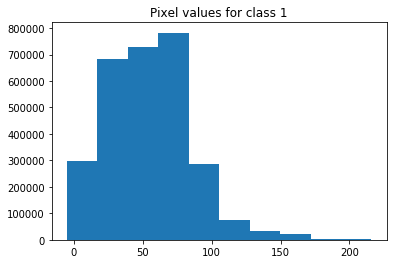

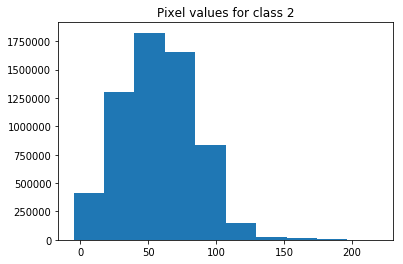

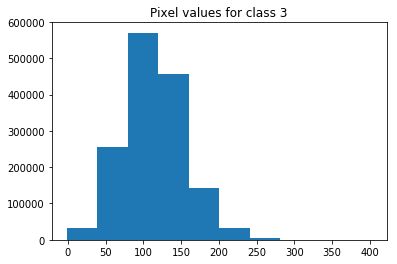

In [5]:
# Create histograms for each class
dict_labels = {1:[], 2:[], 3:[]}
for key in dict_labels:
    dict_labels[key] = xdata[np.where(labels[...,key] == 1)]
    histogram_values = plt.hist(dict_labels[key])
    plt.title('Pixel values for class ' + str(key))
    plt.show()

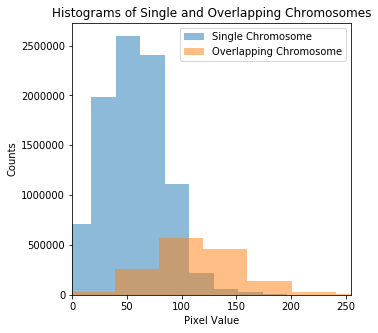

In [6]:
# Create histogram of single vs overlapping chromosomes
single_chromosomes = np.concatenate([dict_labels[1][:,0], dict_labels[2][:,0]])
plt.figure(figsize=(5,5))
plt.hist(single_chromosomes, alpha=0.5, label='Single Chromosome')
plt.hist(dict_labels[3][:,0], alpha=0.5, label='Overlapping Chromosome')
plt.title('Histograms of Single and Overlapping Chromosomes')
plt.xlim([0, 255])
plt.ylabel('Counts')
plt.xlabel('Pixel Value')
plt.legend(loc='best')
plt.savefig('histogram.png', dpi=300)
plt.show()

In [ ]:
from __future__ import print_function
from __future__ import absolute_import

import warnings

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import concatenate
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras import callbacks

def OverlapSegmentationNet(input_tensor=None, input_shape=None, pooling=None):

    

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x_1a = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x_1a)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x_2a = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x_2a)


    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)

    x_2b = Conv2DTranspose(128, (2, 2), strides=(2, 2), input_shape=(None,23, 23, 1), name='block3_deconv1')(x)

    # Deconv Block 1
    x = concatenate([x_2a, x_2b])#, axis=-1)
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='dblock1_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='dblock1_conv2')(x)
    x_1b = Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), name='dblock1_deconv')(x)

    # Deconv Block 2
    x = concatenate([x_1a, x_1b], input_shape=(None,92, 92, None))#, axis=-1, name='dbock2_concat') # keras.layers.concatenate([encoded_a, encoded_b], axis=-1)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='dblock2_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='dblock2_conv2')(x)
    # Output convolution. Number of filters should equal number of channels of the output
    x = Conv2D(4, (1, 1), activation=None, padding='same', name='dblock2_conv3')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model
    model = Model(inputs, x, name='OverlapSegmentationNet')


    return model


Using TensorFlow backend.


Train on 10747 samples, validate on 2687 samples
Epoch 1/1
10747/10747 [==============================] - 2724s 253ms/step - loss: 0.0269 - val_loss: 0.0112


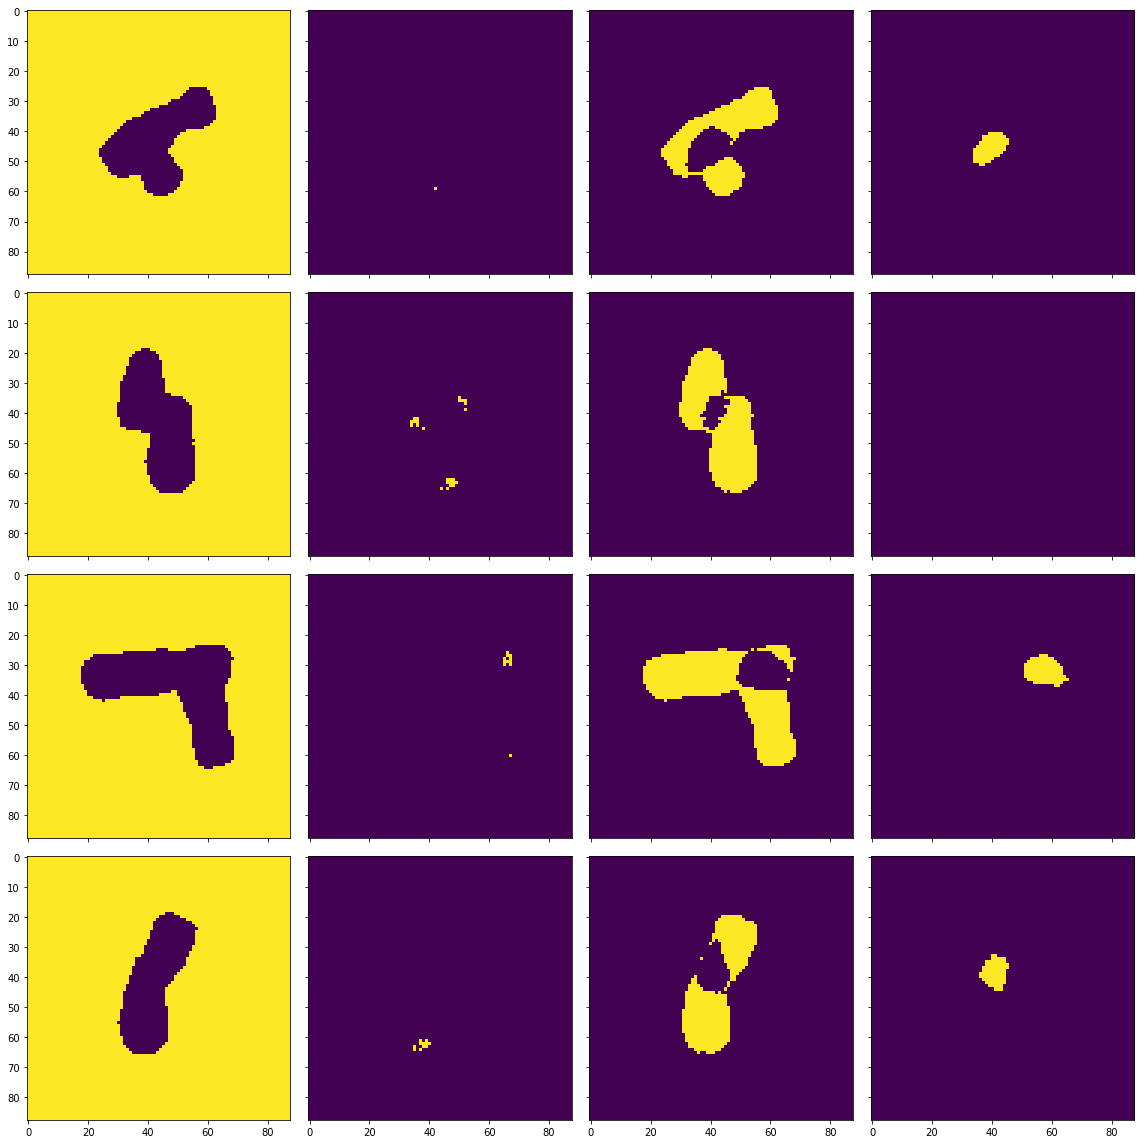

Training IOU: [0.9982664866914408, 0.025698168859425732, 0.6663288488185, 0.6285631723610682]
Training accuracy: 0.9622317361100965


In [ ]:
import matplotlib.pyplot as plt
import numpy as n
import os

import tensorflow as tf

# Load data
xdata = np.load('xdata_88x88.npy')
labels = np.load('ydata_88x88_0123_onehot.npy')
train_test_boundary_index = round(13434*.8)

model = OverlapSegmentationNet(input_shape=(88,88,1))

# Choose loss
model.compile(loss='mean_squared_error', optimizer='adam')

# Specify the number of epochs to run
num_epoch = 5
for i in range(num_epoch):
    
    # Fit
    model.fit(x=xdata, y=labels, epochs=1, validation_split=0.2) 
    os.makedirs('models', exist_ok=True)
    filename = 'models/savedmodel_' + str(i) + 'epoch'
    model.save(filename)
    
    # Predict and plot images
    predictions = model.predict(xdata[0:4,...])
    plotSamplesOneHots(predictions[0:4,...].round())
   
    # Calculate mIOU
    y_pred_train = model.predict(xdata[0:train_test_boundary_index,...]).round()
    trainIOU = IOU(y_pred_train, labels[0:train_test_boundary_index,...])
    print('Training IOU: ' + str(trainIOU))
    trainAccuracy = globalAccuracy(y_pred_train, labels[0:train_test_boundary_index,...])
    print('Training accuracy: ' + str(trainAccuracy))
    del y_pred_train
    
    y_pred_test = model.predict(xdata[train_test_boundary_index:,...]).round()
    testIOU = IOU(y_pred_test, labels[train_test_boundary_index:,...])
    print('Testing IOU: ' + str(testIOU))
    testAccuracy = globalAccuracy(y_pred_test, labels[train_test_boundary_index:,...])
    print('Testing accuracy: ' + str(testAccuracy))
    del y_pred_test

